#벡터 자동 회귀 분석(Vector Auto Regression)
VAR 모델은 예측변수의 과거 값뿐만 아니라 종속변수와 의존성이 있는 변수들까지 고려하여 선형함수로 나타내는 확률적 과정이다.

1. 데이터셋 준비
2. 정상성 확인
3. 모델링
4. 예측



##데이터셋 준비

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools

In [2]:
data = sm.datasets.macrodata.load_pandas().data
data.head()


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
mydata = data[["realgdp", 'realdpi']]
mydata.index = data["year"]
mydata.head()

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


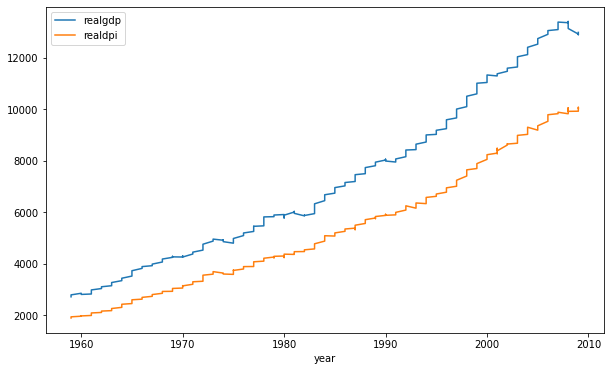

In [4]:
mydata.plot(figsize = (10,6))

##정상성 확인

In [5]:
adfuller_test = adfuller(mydata['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.7504627967647162
p-value: 0.9982455372335032


In [6]:
adfuller_test = adfuller(mydata['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 2.986025351954683
p-value: 1.0


p value가 충분히 작지 않아서 둘 다 정상성을 만족하지 않는다.

###비정상성 시계열 데이터를 정상성 시계열 데이터로 변환
1. 차분
2. 로그 변환

In [7]:
mydata_diff = mydata.diff().dropna()

In [8]:
adfuller_test = adfuller(mydata_diff['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [9]:
adfuller_test = adfuller(mydata_diff['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -8.864893340673005
p-value: 1.4493606159108354e-14


##모델링


In [10]:
train = mydata_diff.iloc[:-10,:]
test = mydata_diff.iloc[-10:,:]

###VAR모델의 최적 순서 찾기

In [11]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


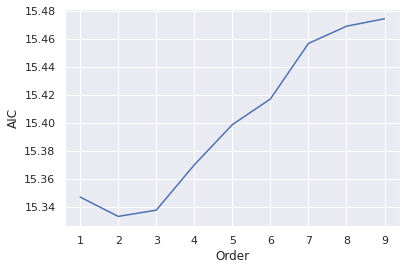

In [12]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [13]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Sep, 2022
Time:                     03:26:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

##예측

In [14]:
laaged_values = train.values[-2:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,61.872982,47.739232
2007.0,53.948996,41.742951
2007.0,56.171082,42.552316
2008.0,54.953081,42.023999
2008.0,55.109616,42.001007
2008.0,54.865410,41.937065
2008.0,54.841362,41.893996
2009.0,54.775171,41.878378
2009.0,54.754309,41.859837


In [15]:
forecast["realgdp_forecasted"] = mydata["realgdp"].iloc[-10-1] + forecast['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = mydata["realdpi"].iloc[-10-1] + forecast['realdpi_1d'].cumsum() 
forecast

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,61.872982,47.739232,13161.773982,9877.939232
2007.0,53.948996,41.742951,13215.722978,9919.682183
2007.0,56.171082,42.552316,13271.894060,9962.234500
2008.0,54.953081,42.023999,13326.847141,10004.258499
2008.0,55.109616,42.001007,13381.956757,10046.259506
2008.0,54.865410,41.937065,13436.822166,10088.196571
2008.0,54.841362,41.893996,13491.663528,10130.090566
2009.0,54.775171,41.878378,13546.438699,10171.968945
2009.0,54.754309,41.859837,13601.193008,10213.828781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


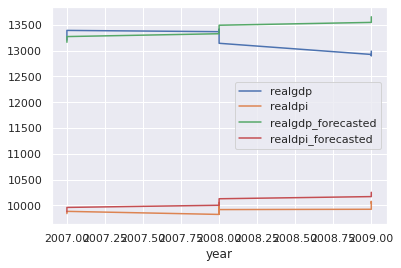

In [16]:
test = mydata.iloc[-10:,:]
test["realgdp_forecasted"] = forecast["realgdp_forecasted"]
test["realdpi_forecasted"] = forecast["realdpi_forecasted"]
test.plot()